In [7]:
! pip install uv
! uv pip install numpy pandas wfdb matplotlib ecgmentations pytorch_metric_learning --quiet
! uv pip install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/20.1 MB ? eta -:--:--  Downloading uv-0.9.9-py3-none-manylinux_2_28_aarch64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 11.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 11.6 MB/s  0:00:01
Using Python 3.12.3 environment at: /home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv
⠙ Resolving dependencies...                                                     Using Python 3.12.3 environment at: /home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv
Resolved 13 packages in 1.31s                                        
Resolved 13 packages in 1.31s                                        
⠙ Preparing packages... (0/2)                                                   
⠙ Preparing packages... (0/2)-------------------     0 B/2.40 MiB            
⠙ Preparing packages... (0/2)------------------- 8.0

In [8]:
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()

(False, False)

Checkpointing Manager

In [9]:
from src import CheckpointManager
from src import train
from src import ECGContrastiveTrainDataset, ECGDataset, DualAugmenter
from pytorch_metric_learning.losses import NTXentLoss

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 280.24M parameters

Simple Model Summary:

Compare to complex model: 280.24M parameters


In [10]:
import ast

import numpy as np
import pandas as pd
import wfdb


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_lr[:2500]]
    else:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_hr[:2500]]
    data = np.array([signal for signal, meta in data])
    return data


path = "/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path + "/ptbxl_database.csv", index_col="ecg_id")[:2500]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + "/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)




# Split data into train, validation, and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass
# Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [11]:
X_val.shape, X_test.shape, X_train.shape

((312, 1000, 12), (324, 1000, 12), (1864, 1000, 12))

In [12]:
# Check the data structure - see examples of diagnostic_superclass
print("Sample y_train values:")
print(y_train.head(10))
print("\nValue counts:")
print(y_train.apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts())
print("\nSample with multiple labels:")
multi_label_examples = y_train[y_train.apply(lambda x: isinstance(x, list) and len(x) > 1)]
print(f"Found {len(multi_label_examples)} samples with multiple labels")
if len(multi_label_examples) > 0:
    print(multi_label_examples.head())

Sample y_train values:
ecg_id
1     [NORM]
2     [NORM]
3     [NORM]
4     [NORM]
5     [NORM]
6     [NORM]
7     [NORM]
11    [NORM]
12    [NORM]
13    [NORM]
Name: diagnostic_superclass, dtype: object

Value counts:
diagnostic_superclass
1    1466
2     300
3      64
4      21
0      13
Name: count, dtype: int64

Sample with multiple labels:
Found 385 samples with multiple labels
ecg_id
45      [HYP, CD]
50       [CD, MI]
77       [CD, MI]
87     [CD, STTC]
102    [CD, STTC]
Name: diagnostic_superclass, dtype: object


In [13]:
# Get all unique diagnostic classes
all_labels = []
for labels_list in pd.concat([y_train, y_val, y_test]):
    if isinstance(labels_list, list):
        all_labels.extend(labels_list)

unique_diagnostic_classes = sorted(set(all_labels))
print(f"Unique diagnostic classes: {unique_diagnostic_classes}")
print(f"Total number of classes: {len(unique_diagnostic_classes)}")

Unique diagnostic classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Total number of classes: 5


In [14]:
# Filter out rows with multiple labels (keep only single-label samples)
def filter_single_label(y_series, X_array):
    """Filter to keep only samples with exactly one label"""
    single_label_mask = y_series.apply(lambda x: isinstance(x, list) and len(x) == 1)
    y_filtered = y_series[single_label_mask].copy()
    X_filtered = X_array[single_label_mask.values]
    return X_filtered, y_filtered

# Apply filtering to train, val, and test sets
X_train_filtered, y_train_filtered = filter_single_label(y_train, X_train)
X_val_filtered, y_val_filtered = filter_single_label(y_val, X_val)
X_test_filtered, y_test_filtered = filter_single_label(y_test, X_test)

print("Original sizes:")
print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")
print("\nFiltered sizes (single label only):")
print(f"Train: {len(y_train_filtered)}, Val: {len(y_val_filtered)}, Test: {len(y_test_filtered)}")
print(f"\nRemoved {len(y_train) - len(y_train_filtered)} multi-label samples from train")
print(f"Removed {len(y_val) - len(y_val_filtered)} multi-label samples from val")
print(f"Removed {len(y_test) - len(y_test_filtered)} multi-label samples from test")

Original sizes:
Train: 1864, Val: 312, Test: 324

Filtered sizes (single label only):
Train: 1466, Val: 224, Test: 261

Removed 398 multi-label samples from train
Removed 88 multi-label samples from val
Removed 63 multi-label samples from test


In [15]:
# Create label mapping from diagnostic class strings to integers
label_to_idx = {label: idx for idx, label in enumerate(unique_diagnostic_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Label mapping:")
for label, idx in label_to_idx.items():
    print(f"  {label} -> {idx}")

# Convert labels from list of strings to integers
def map_labels_to_int(y_series, label_mapping):
    """Convert single-element label lists to integer labels"""
    return y_series.apply(lambda x: label_mapping[x[0]])

y_train_int = map_labels_to_int(y_train_filtered, label_to_idx)
y_val_int = map_labels_to_int(y_val_filtered, label_to_idx)
y_test_int = map_labels_to_int(y_test_filtered, label_to_idx)

print("\nLabel distribution in train set:")
print(y_train_int.value_counts().sort_index())
print("\nLabel distribution in val set:")
print(y_val_int.value_counts().sort_index())
print("\nLabel distribution in test set:")
print(y_test_int.value_counts().sort_index())

Label mapping:
  CD -> 0
  HYP -> 1
  MI -> 2
  NORM -> 3
  STTC -> 4

Label distribution in train set:
diagnostic_superclass
0    134
1     51
2    113
3    975
4    193
Name: count, dtype: int64

Label distribution in val set:
diagnostic_superclass
0     20
1      7
2     20
3    146
4     31
Name: count, dtype: int64

Label distribution in test set:
diagnostic_superclass
0     25
1     10
2     26
3    161
4     39
Name: count, dtype: int64


In [16]:
# Summary of processed data
print("="*60)
print("SUMMARY: Data Processing Complete")
print("="*60)
print("\nLabel Mapping Dictionary:")
print(f"  label_to_idx = {label_to_idx}")
print(f"  idx_to_label = {idx_to_label}")
print("\nFinal Dataset Shapes:")
print(f"  X_train_filtered: {X_train_filtered.shape}, y_train_int: {y_train_int.shape}")
print(f"  X_val_filtered: {X_val_filtered.shape}, y_val_int: {y_val_int.shape}")
print(f"  X_test_filtered: {X_test_filtered.shape}, y_test_int: {y_test_int.shape}")
print("\nNote: Multi-label samples have been removed.")
print("      Labels are now integers in range [0, 4]")

SUMMARY: Data Processing Complete

Label Mapping Dictionary:
  label_to_idx = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}
  idx_to_label = {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

Final Dataset Shapes:
  X_train_filtered: (1466, 1000, 12), y_train_int: (1466,)
  X_val_filtered: (224, 1000, 12), y_val_int: (224,)
  X_test_filtered: (261, 1000, 12), y_test_int: (261,)

Note: Multi-label samples have been removed.
      Labels are now integers in range [0, 4]


# Data Augmenter and Dataset Classes

In [17]:
# Create classification datasets
# The training dataset will compute the normalization stats
# Val and test will reuse those stats for consistency

train_dataset_classification = ECGDataset(
    X=X_train_filtered,
    y=y_train_int
)

# Reuse training stats for validation and test
val_dataset_classification = ECGDataset(
    X=X_val_filtered,
    y=y_val_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

test_dataset_classification = ECGDataset(
    X=X_test_filtered,
    y=y_test_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

print(f"Train dataset size: {len(train_dataset_classification)}")
print(f"Validation dataset size: {len(val_dataset_classification)}")
print(f"Test dataset size: {len(test_dataset_classification)}")
print(f"Number of classes: {test_dataset_classification.num_classes}")

print(f"\nNormalization stats computed from training set:")
print(f"  Channel means shape: {train_dataset_classification.channel_means.shape}")
print(f"  Channel stds shape: {train_dataset_classification.channel_stds.shape}")
print(f"  Std range: [{train_dataset_classification.channel_stds.min():.6f}, {train_dataset_classification.channel_stds.max():.6f}]")

# Test a sample
sample_signal, sample_label = val_dataset_classification[-1]
print(f"\nSample signal shape: {sample_signal.shape}")
print(f"Sample label (numerical): {sample_label}")

Train dataset size: 1466
Validation dataset size: 224
Test dataset size: 261
Number of classes: 5

Normalization stats computed from training set:
  Channel means shape: (12,)
  Channel stds shape: (12,)
  Std range: [0.118303, 0.328315]

Sample signal shape: torch.Size([1000, 12])
Sample label (numerical): 3


In [18]:
# Create DataLoaders for classification training
from torch.utils.data import DataLoader

batch_size = 64

train_loader_classification = DataLoader(
    train_dataset_classification, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader_classification = DataLoader(
    val_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader_classification = DataLoader(
    test_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created DataLoaders for classification:")
print(f"  Train: {len(train_dataset_classification)} samples, {len(train_loader_classification)} batches")
print(f"  Val:   {len(val_dataset_classification)} samples, {len(val_loader_classification)} batches")
print(f"  Test:  {len(test_dataset_classification)} samples, {len(test_loader_classification)} batches")

# Verify the data format
for signals, labels in train_loader_classification:
    print(f"\nBatch shapes:")
    print(f"  Signals: {signals.shape}")  # Should be (batch_size, time_steps, num_channels)
    print(f"  Labels: {labels.shape}, dtype: {labels.dtype}")  # Should be (batch_size,) with int dtype
    print(f"  Label range: [{labels.min()}, {labels.max()}]")
    break

Created DataLoaders for classification:
  Train: 1466 samples, 23 batches
  Val:   224 samples, 4 batches
  Test:  261 samples, 5 batches


/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



Batch shapes:
  Signals: torch.Size([64, 1000, 12])
  Labels: torch.Size([64]), dtype: torch.int64
  Label range: [0, 4]


In [19]:
import ecgmentations as E
from scipy.spatial.distance import cosine

# Define augmentation pool
augmentation_pool = [
    E.TimeShift(p=1.0),
    E.GaussNoise(p=1.0),
    E.PowerlineNoise(p=1.0, ecg_frequency=60),
    E.RespirationNoise(p=1.0),
    E.AmplitudeScale(p=1.0),
    E.TimeCutout(p=1.0),
]

# Create dual augmenter with both min and max similarity thresholds
dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.65,   # Augmentations must be at least 65% similar
    max_similarity=0.95,  # But not more than 95% similar
    max_retries=5,
)

# Create contrastive datasets
# Training dataset computes normalization stats
train_dataset = ECGContrastiveTrainDataset(
    X=X_train_filtered, 
    y=y_train_int, 
    dual_augmenter=dual_augmenter
)

# Val and test reuse training stats
val_dataset = ECGContrastiveTrainDataset(
    X=X_val_filtered, 
    y=y_val_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

test_dataset = ECGContrastiveTrainDataset(
    X=X_test_filtered, 
    y=y_test_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

print(f"✓ Created contrastive datasets")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

print(f"\n✓ Normalization stats from training set:")
print(f"  Channel means: {train_dataset.channel_means}")
print(f"  Channel stds: {train_dataset.channel_stds}")

# Test augmentation on a sample from the dataset
aug1, aug2 = train_dataset[0]
print(f"\n✓ Sample augmentation test:")
print(f"  Aug1 shape: {aug1.shape}")
print(f"  Aug2 shape: {aug2.shape}")
print(f"  Are they identical? {torch.equal(aug1, aug2)}")

# Calculate similarity between augmented views
similarity = 1 - cosine(aug1.numpy().flatten(), aug2.numpy().flatten())
print(f"  Cosine similarity: {similarity:.4f}")
print(f"  Within range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
      f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

✓ Created contrastive datasets
  Train: 1466 samples
  Val: 224 samples
  Test: 261 samples

✓ Normalization stats from training set:
  Channel means: [-5.7694950e-04 -2.1550136e-04  3.6097338e-04  3.8910232e-04
 -4.1614939e-04  9.6884040e-05  2.4732196e-04 -7.4475032e-04
 -1.4518786e-03 -1.1088240e-03 -3.4272374e-04 -4.1160983e-04]
  Channel stds: [0.14818126 0.16284712 0.13891266 0.13935892 0.11830257 0.13183425
 0.22070584 0.32831514 0.30157217 0.28024685 0.26714414 0.24654382]

✓ Sample augmentation test:
  Aug1 shape: torch.Size([1000, 12])
  Aug2 shape: torch.Size([1000, 12])
  Are they identical? False
  Cosine similarity: 0.8955
  Within range [0.65, 0.95]? True


Visualize the signals?

## Visualization: Raw Data

Let's visualize some raw ECG signals before any preprocessing to understand the data structure.

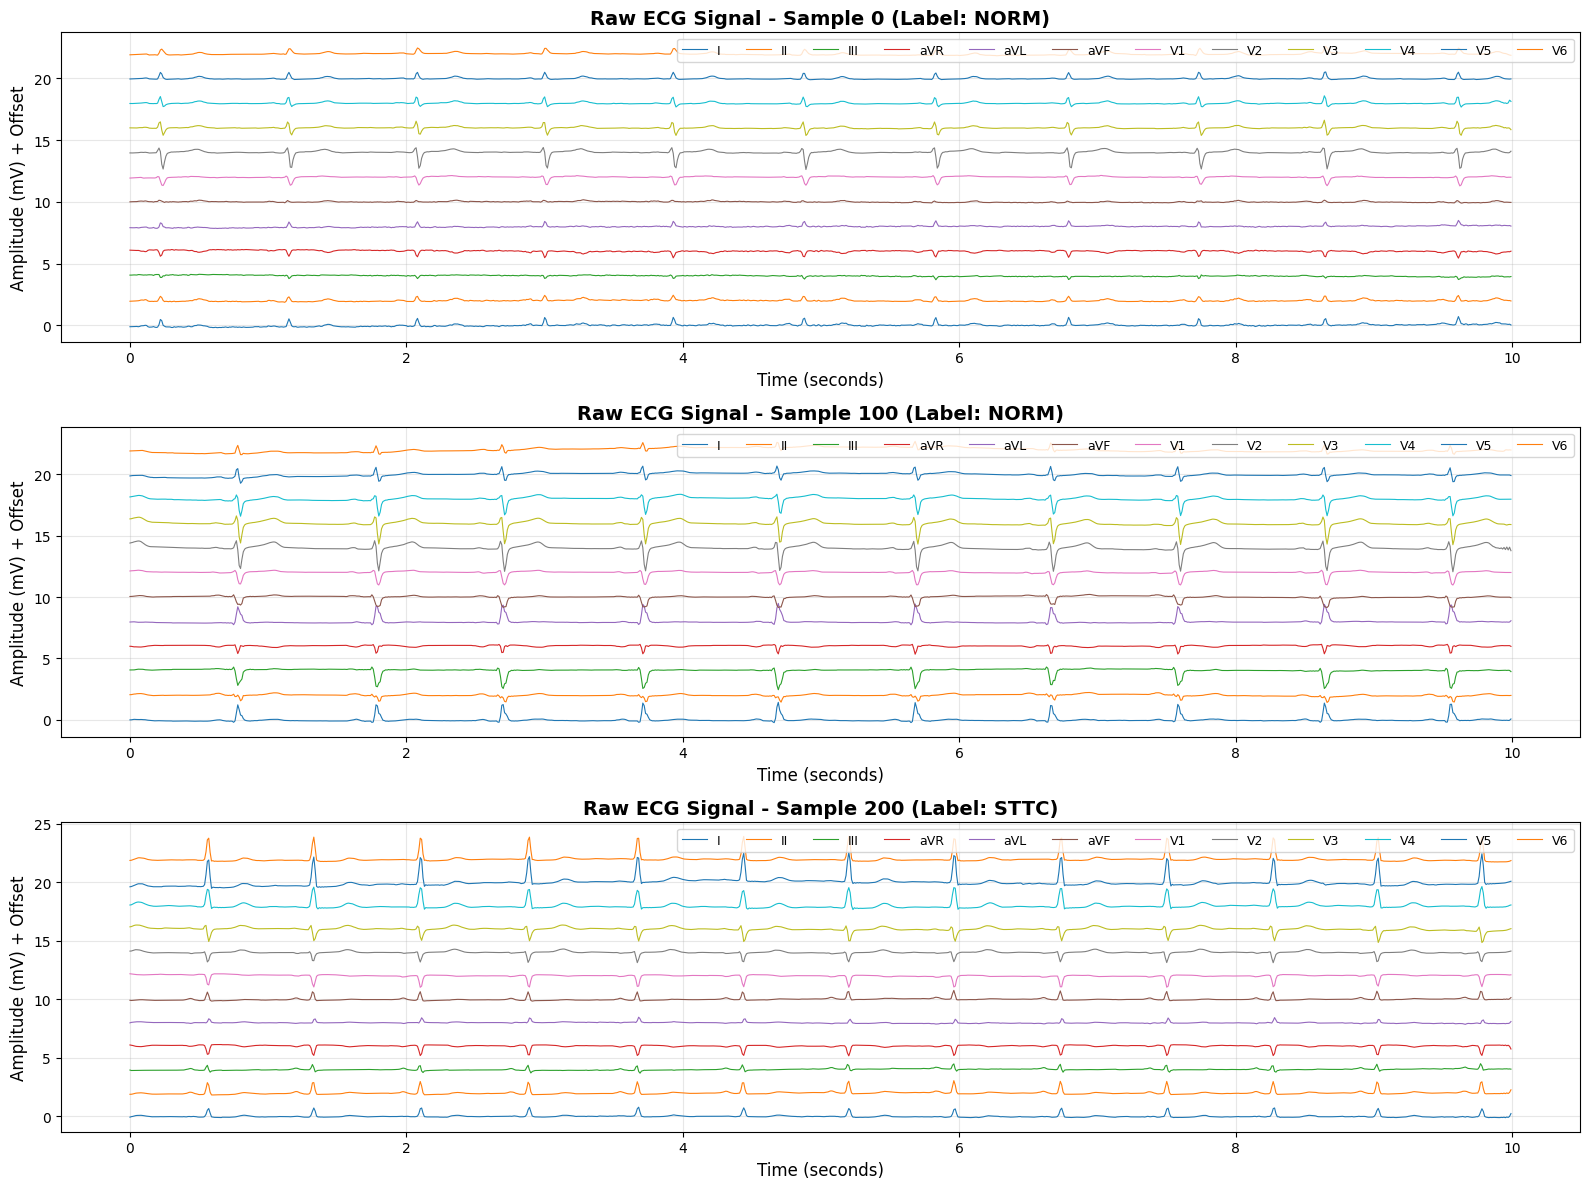

Raw signal shape (time, channels): (1000, 12)
Value range: [-11.1440, 8.2470]
Mean: -0.0003, Std: 0.2192
Sampling rate assumed for visualizations: 100 Hz


In [20]:
import matplotlib.pyplot as plt
import numpy as np

SAMPLING_RATE = 100  # Hz sampling rate used by PTB-XL low-resolution signals

# Select a few samples to visualize
sample_indices = [0, 100, 200]  # Different samples
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

for idx, sample_idx in enumerate(sample_indices):
    # Get raw signal
    raw_signal = X_train_filtered[sample_idx]  # Shape: (time_steps, 12)
    label = y_train_int.iloc[sample_idx]
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(raw_signal.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        # Offset each lead for visibility
        offset = lead_idx * 2
        ax.plot(time_axis, raw_signal[:, lead_idx] + offset, label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude (mV) + Offset', fontsize=12)
    ax.set_title(f'Raw ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw signal shape (time, channels): {raw_signal.shape}")
print(f"Value range: [{X_train_filtered.min():.4f}, {X_train_filtered.max():.4f}]")
print(f"Mean: {X_train_filtered.mean():.4f}, Std: {X_train_filtered.std():.4f}")
print(f"Sampling rate assumed for visualizations: {SAMPLING_RATE} Hz")

## Visualization: After Preprocessing (Normalized)

Now let's see the same signals after preprocessing (normalization).
Each tensor coming from `train_dataset_classification` is already shaped as `(time_steps, channels)`,
so the plots below directly reuse that convention and only offset each lead for readability.

Example preprocessed tensor shape (time, channels): (1000, 12)


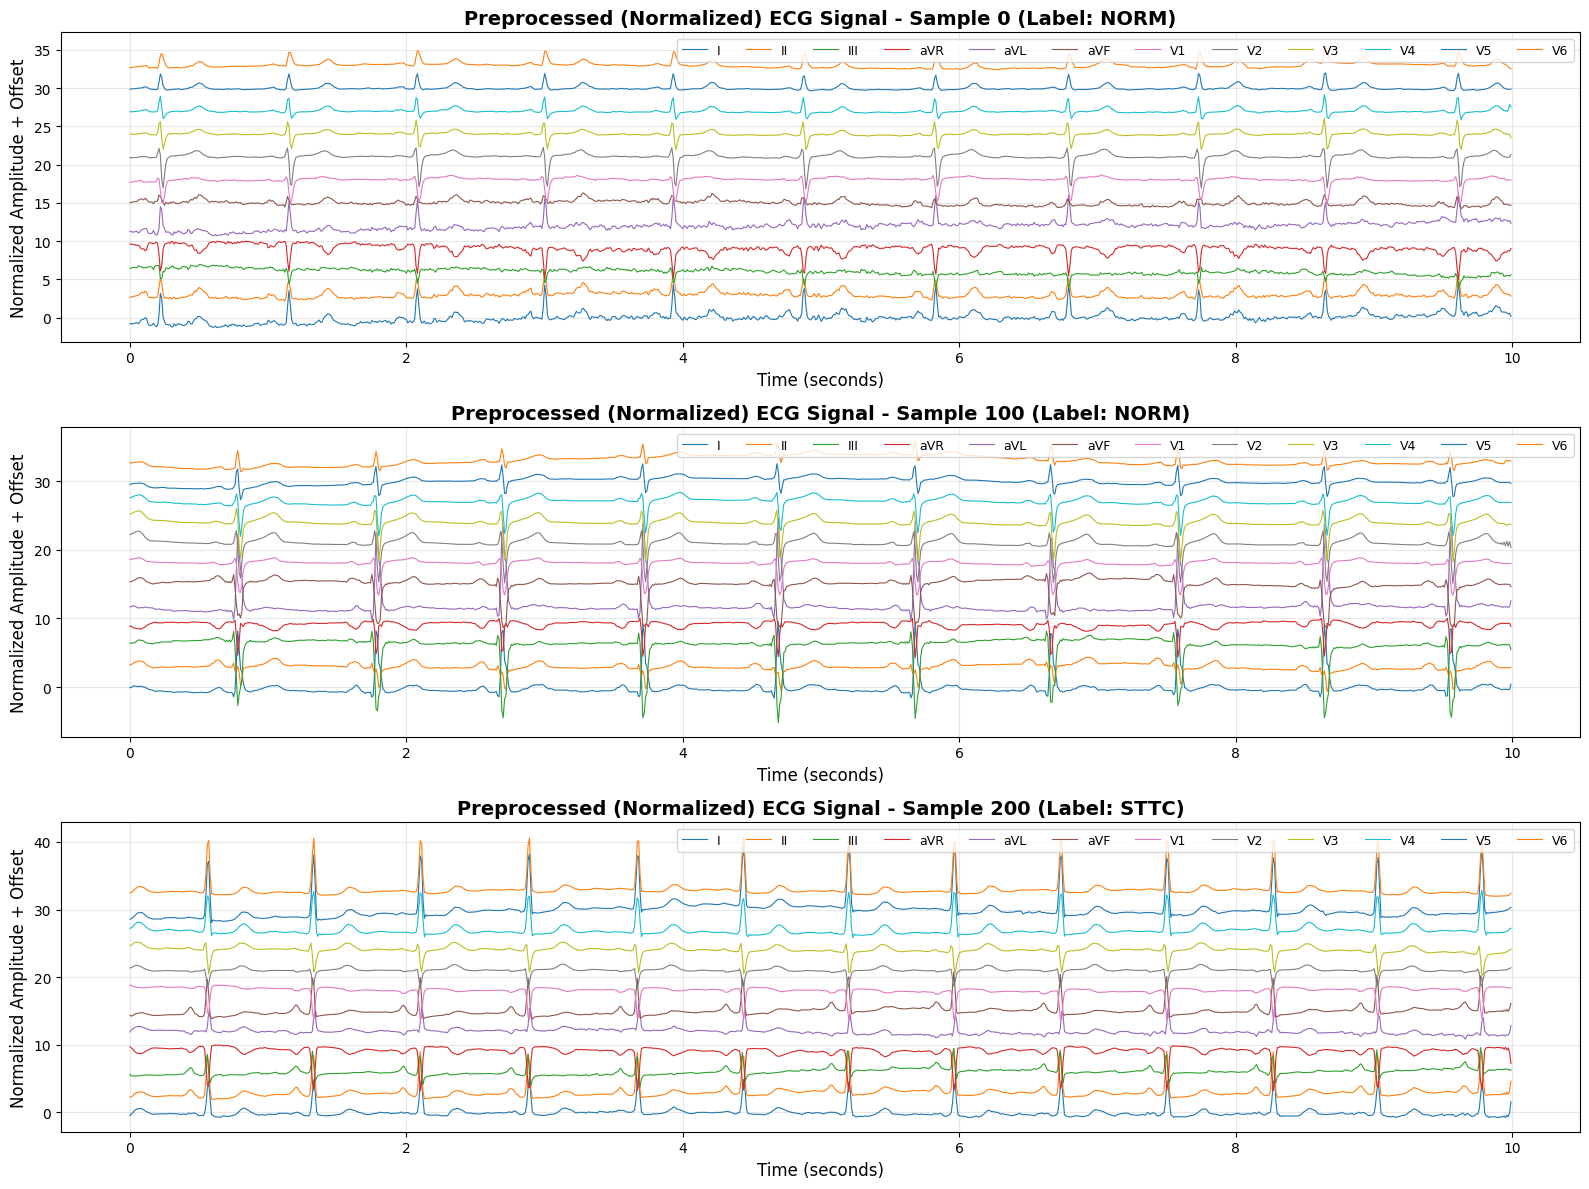

Preprocessed signal shape (time, channels): (1000, 12)
Value range: [-5.9802, 9.6740]
Mean per channel: 0.000372
Std per channel: 0.866161

Normalization stats used:
  Channel means: min=-0.0015, max=0.0004
  Channel stds: min=0.118303, max=0.328315


In [21]:
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

dataset_shape_logged = False
last_preprocessed_np = None

for idx, sample_idx in enumerate(sample_indices):
    # Get preprocessed signal from the dataset (time_steps, num_channels)
    preprocessed_signal, label = train_dataset_classification[sample_idx]
    preprocessed_np = preprocessed_signal.numpy()
    last_preprocessed_np = preprocessed_np
    
    if not dataset_shape_logged:
        print(f"Example preprocessed tensor shape (time, channels): {preprocessed_np.shape}")
        dataset_shape_logged = True
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(preprocessed_np.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        offset = lead_idx * 3  # Slightly larger offset for normalized data
        ax.plot(time_axis, preprocessed_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Normalized Amplitude + Offset', fontsize=12)
    ax.set_title(f'Preprocessed (Normalized) ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if last_preprocessed_np is not None:
    print(f"Preprocessed signal shape (time, channels): {last_preprocessed_np.shape}")
    print(f"Value range: [{last_preprocessed_np.min():.4f}, {last_preprocessed_np.max():.4f}]")
    print(f"Mean per channel: {last_preprocessed_np.mean(axis=0).mean():.6f}")
    print(f"Std per channel: {last_preprocessed_np.std(axis=0).mean():.6f}")
print(f"\nNormalization stats used:")
print(f"  Channel means: min={train_dataset_classification.channel_means.min():.4f}, max={train_dataset_classification.channel_means.max():.4f}")
print(f"  Channel stds: min={train_dataset_classification.channel_stds.min():.6f}, max={train_dataset_classification.channel_stds.max():.6f}")

## Visualization: After Augmentation (Contrastive Learning)

Finally, let's see how augmentations create two different views of the same signal for contrastive learning.
The augmented tensors also follow the `(time_steps, channels)` layout, which keeps the interpretation consistent across the pipeline.

Augmented tensor shape (time, channels): (1000, 12)
Pair 1 - Cosine Similarity: 0.8168
  Within target range [0.65, 0.95]? True
Pair 2 - Cosine Similarity: 0.8814
  Within target range [0.65, 0.95]? True
Pair 3 - Cosine Similarity: 0.7016
  Within target range [0.65, 0.95]? True


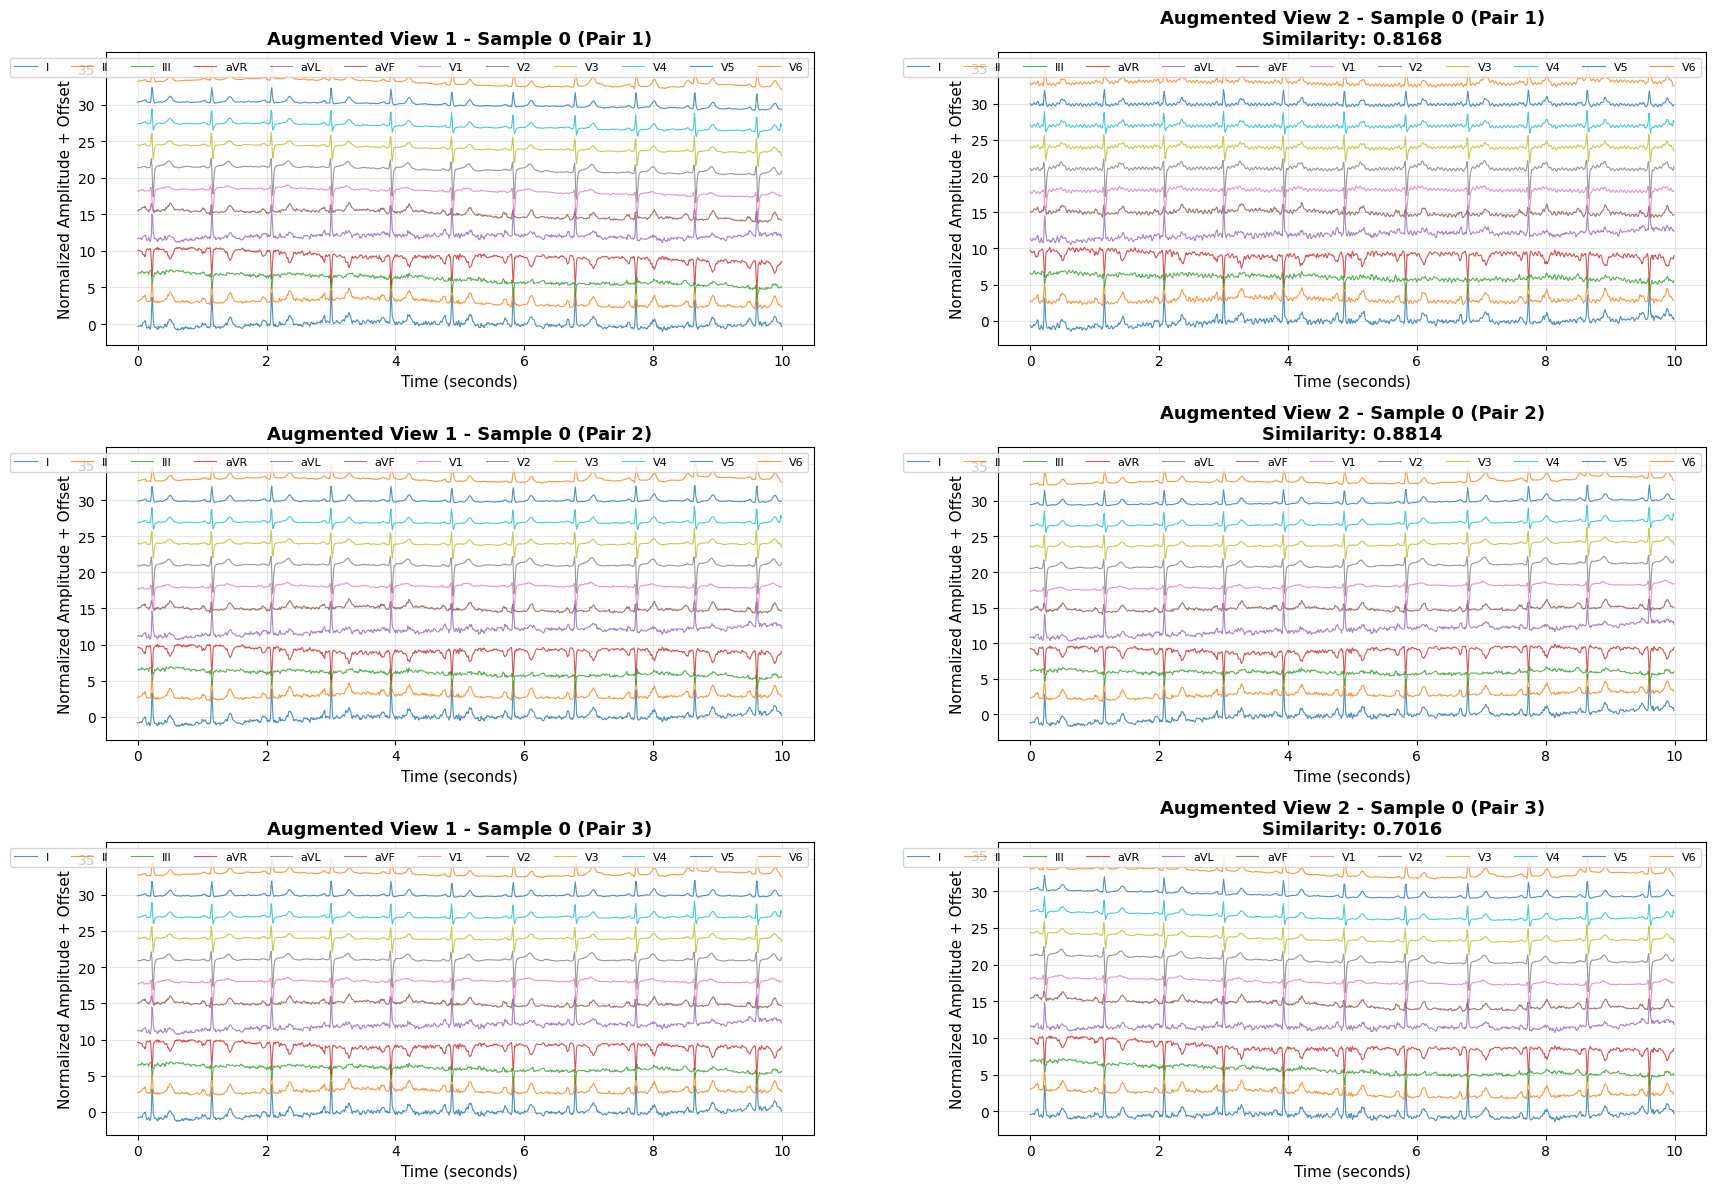


✓ Augmentation creates controlled diversity:
  Min similarity threshold: 0.65
  Max similarity threshold: 0.95
  This ensures views are similar but not identical for effective contrastive learning.


In [22]:
from scipy.spatial.distance import cosine

# Select one sample to show augmentations
sample_idx = 0
n_views = 3  # Show 3 different augmentation pairs

fig, axes = plt.subplots(n_views, 2, figsize=(18, 4 * n_views))

for view_idx in range(n_views):
    # Get augmented views from contrastive dataset (time_steps, num_channels)
    aug1, aug2 = train_dataset[sample_idx]
    aug1_np = aug1.numpy()
    aug2_np = aug2.numpy()
    
    if view_idx == 0:
        print(f"Augmented tensor shape (time, channels): {aug1_np.shape}")
    
    # Calculate similarity between the two views
    similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
    
    time_axis = np.arange(aug1_np.shape[0]) / SAMPLING_RATE
    
    # Plot first augmented view
    ax1 = axes[view_idx, 0]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax1.plot(time_axis, aug1_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax1.set_xlabel('Time (seconds)', fontsize=11)
    ax1.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax1.set_title(f'Augmented View 1 - Sample {sample_idx} (Pair {view_idx + 1})', 
                 fontsize=13, fontweight='bold')
    ax1.legend(ncol=12, loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot second augmented view
    ax2 = axes[view_idx, 1]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax2.plot(time_axis, aug2_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax2.set_xlabel('Time (seconds)', fontsize=11)
    ax2.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax2.set_title(f'Augmented View 2 - Sample {sample_idx} (Pair {view_idx + 1})\nSimilarity: {similarity:.4f}', 
                 fontsize=13, fontweight='bold')
    ax2.legend(ncol=12, loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    print(f"Pair {view_idx + 1} - Cosine Similarity: {similarity:.4f}")
    print(f"  Within target range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
          f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

plt.tight_layout()
plt.show()

print(f"\n✓ Augmentation creates controlled diversity:")
print(f"  Min similarity threshold: {dual_augmenter.min_similarity}")
print(f"  Max similarity threshold: {dual_augmenter.max_similarity}")
print(f"  This ensures views are similar but not identical for effective contrastive learning.")

## Visualization: Side-by-Side Comparison

Let's create a comprehensive comparison showing raw, preprocessed, and augmented versions of the same signal,
keeping the `(time_steps, channels)` orientation consistent at every stage.

Side-by-side tensor shapes (time, channels): raw=(1000, 12), preprocessed=(1000, 12), aug=(1000, 12)


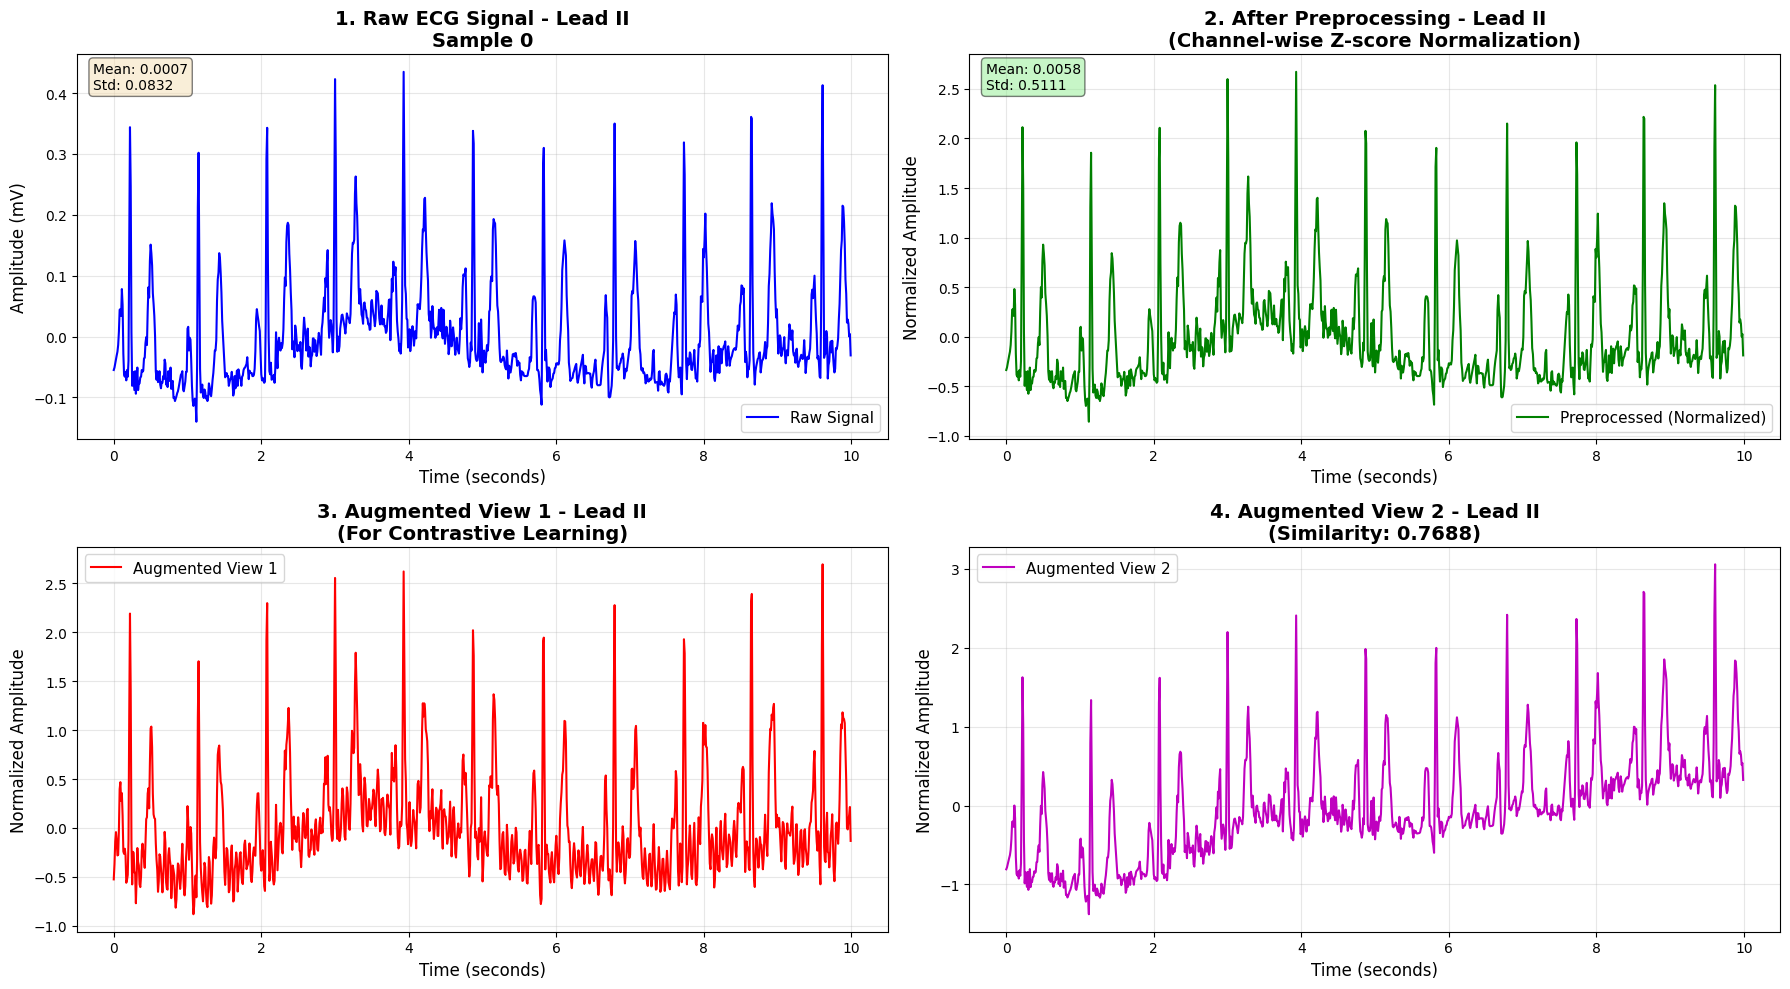

DATA PREPROCESSING PIPELINE SUMMARY

1. RAW DATA:
   - Shape (time, channels): (1000,)
   - Range: [-0.1400, 0.4350]
   - Mean: 0.0007, Std: 0.0832

2. AFTER PREPROCESSING (Normalization):
   - Channel-wise Z-score normalization: (x - mean) / std
   - Shape (time, channels): (1000,)
   - Range: [-0.8584, 2.6725]
   - Mean: 0.005763, Std: 0.5111

3. AFTER AUGMENTATION:
   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,
     RespirationNoise, AmplitudeScale, TimeCutout
   - Two views created with controlled similarity: [0.65, 0.95]
   - Actual similarity: 0.7688
   - View 1 range: [-0.8816, 2.6951]
   - View 2 range: [-1.3783, 3.0573]



In [23]:
# Pick a sample and show one lead for clarity
sample_idx = 0
lead_idx = 1  # Lead II (commonly used in ECG analysis)

# Get the data at different stages
raw_signal = X_train_filtered[sample_idx][:, lead_idx]
preprocessed_signal, _ = train_dataset_classification[sample_idx]
preprocessed_np = preprocessed_signal.numpy()
aug1, aug2 = train_dataset[sample_idx]
aug1_np = aug1.numpy()
aug2_np = aug2.numpy()

print(f"Side-by-side tensor shapes (time, channels): raw={X_train_filtered[sample_idx].shape}, preprocessed={preprocessed_np.shape}, aug={aug1_np.shape}")

preprocessed_signal = preprocessed_np[:, lead_idx]
aug1_signal = aug1_np[:, lead_idx]
aug2_signal = aug2_np[:, lead_idx]

time_axis = np.arange(len(raw_signal)) / SAMPLING_RATE

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Raw signal
axes[0, 0].plot(time_axis, raw_signal, 'b-', linewidth=1.5, label='Raw Signal')
axes[0, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 0].set_ylabel('Amplitude (mV)', fontsize=12)
axes[0, 0].set_title(f'1. Raw ECG Signal - Lead {lead_names[lead_idx]}\nSample {sample_idx}', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'Mean: {raw_signal.mean():.4f}\nStd: {raw_signal.std():.4f}',
                transform=axes[0, 0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Preprocessed signal
axes[0, 1].plot(time_axis, preprocessed_signal, 'g-', linewidth=1.5, label='Preprocessed (Normalized)')
axes[0, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Amplitude', fontsize=12)
axes[0, 1].set_title(f'2. After Preprocessing - Lead {lead_names[lead_idx]}\n(Channel-wise Z-score Normalization)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.02, 0.98, f'Mean: {preprocessed_signal.mean():.4f}\nStd: {preprocessed_signal.std():.4f}',
                transform=axes[0, 1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Augmented view 1
axes[1, 0].plot(time_axis, aug1_signal, 'r-', linewidth=1.5, label='Augmented View 1')
axes[1, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 0].set_ylabel('Normalized Amplitude', fontsize=12)
axes[1, 0].set_title(f'3. Augmented View 1 - Lead {lead_names[lead_idx]}\n(For Contrastive Learning)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Augmented view 2
axes[1, 1].plot(time_axis, aug2_signal, 'm-', linewidth=1.5, label='Augmented View 2')
axes[1, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 1].set_ylabel('Normalized Amplitude', fontsize=12)
similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
axes[1, 1].set_title(f'4. Augmented View 2 - Lead {lead_names[lead_idx]}\n(Similarity: {similarity:.4f})', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("DATA PREPROCESSING PIPELINE SUMMARY")
print("=" * 80)
print(f"\n1. RAW DATA:")
print(f"   - Shape (time, channels): {raw_signal.shape}")
print(f"   - Range: [{raw_signal.min():.4f}, {raw_signal.max():.4f}]")
print(f"   - Mean: {raw_signal.mean():.4f}, Std: {raw_signal.std():.4f}")

print(f"\n2. AFTER PREPROCESSING (Normalization):")
print(f"   - Channel-wise Z-score normalization: (x - mean) / std")
print(f"   - Shape (time, channels): {preprocessed_signal.shape}")
print(f"   - Range: [{preprocessed_signal.min():.4f}, {preprocessed_signal.max():.4f}]")
print(f"   - Mean: {preprocessed_signal.mean():.6f}, Std: {preprocessed_signal.std():.4f}")

print(f"\n3. AFTER AUGMENTATION:")
print(f"   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,")
print(f"     RespirationNoise, AmplitudeScale, TimeCutout")
print(f"   - Two views created with controlled similarity: [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]")
print(f"   - Actual similarity: {similarity:.4f}")
print(f"   - View 1 range: [{aug1_signal.min():.4f}, {aug1_signal.max():.4f}]")
print(f"   - View 2 range: [{aug2_signal.min():.4f}, {aug2_signal.max():.4f}]")

print("\n" + "=" * 80)

# SANITIZER PLACEHOLDER

# Evaluation Pipeline
We will plot the test-set in 2-d using PCA and add the labels as the colors.

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np


def extract_embeddings(model, dataloader, device=None):
    """
    Extract embeddings and labels from the model for a given dataset.
    
    Args:
        model: Trained ECGEncoder
        dataloader: DataLoader with (signal, label) pairs
        device: Device to run inference on
        
    Returns:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            representations, _ = model(signals)  # Use representations, not projections
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            # Labels are already integers from ECGDataset
            all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    
    embeddings = np.concatenate(all_embeddings, axis=0)
    labels_array = np.array(all_labels, dtype=int)
    return embeddings, labels_array


def plot_embeddings_2d(embeddings, labels, method='pca', title='ECG Embeddings Visualization', 
                        figsize=(12, 8), label_names=None):
    """
    Plot embeddings in 2D using PCA or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels for each sample
        method: 'pca' or 'tsne'
        title: Plot title
        figsize: Figure size
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    # Ensure labels are numpy array
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Reduce to 2D
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'Explained variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = 't-SNE projection'
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=labels, 
        cmap='tab10', 
        alpha=0.6,
        s=20
    )
    
    # Add legend with optional label names
    if label_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=label_names.get(label, f'Class {label}')) 
                   for label in unique_labels]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=f'Class {label}') 
                   for label in unique_labels]
    
    ax.legend(handles=handles, title='Diagnostic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{title}\n{subtitle}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, unique_labels


def calculate_clustering_metrics(embeddings, labels):
    """
    Calculate clustering quality metrics.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    
    Returns:
        Dictionary with clustering metrics
    """
    # Ensure labels are numpy array of integers
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Get unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Calculate metrics
    metrics = {
        'silhouette_score': silhouette_score(embeddings, labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, labels),
        'n_samples': len(labels),
        'n_classes': len(unique_labels),
        'class_distribution': {int(label): int(count) for label, count in zip(unique_labels, counts)}
    }
    
    return metrics


def print_clustering_metrics(metrics, label_names=None):
    """
    Pretty print clustering metrics.
    
    Args:
        metrics: Dictionary of clustering metrics from calculate_clustering_metrics
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    print("=" * 60)
    print("CLUSTERING QUALITY METRICS")
    print("=" * 60)
    print(f"Number of samples: {metrics['n_samples']}")
    print(f"Number of classes: {metrics['n_classes']}")
    print()
    print("Metrics:")
    print(f"  Silhouette Score:        {metrics['silhouette_score']:.4f}")
    print(f"    (Range: [-1, 1], Higher is better)")
    print(f"    > 0.5: Strong separation")
    print(f"    > 0.3: Reasonable separation")
    print()
    print(f"  Davies-Bouldin Score:    {metrics['davies_bouldin_score']:.4f}")
    print(f"    (Range: [0, ∞], Lower is better)")
    print(f"    < 1.0: Good clustering")
    print()
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"    (Range: [0, ∞], Higher is better)")
    print()
    print("Class Distribution:")
    for label, count in sorted(metrics['class_distribution'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / metrics['n_samples']) * 100
        if label_names is not None:
            label_str = label_names.get(label, f'Class {label}')
        else:
            label_str = f'Class {label}'
        print(f"  {label_str:20s}: {count:4d} samples ({percentage:5.1f}%)")
    print("=" * 60)


# Baseline Model: 1D ResNet for ECG

This is a simpler baseline model based on ResNet architecture, commonly used in time-series classification papers:
- **Paper**: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- **Adapted for 1D signals**: Used in many ECG papers including "Cardiologist-level arrhythmia detection" (Rajpurkar et al., 2017)
- **Architecture**: ResNet-18 style with 1D convolutions
- **Benefits**: Proven architecture, easier to train, fewer parameters

## Model Architecture

In [ ]:
from src import SimpleECGEncoder, SimpleECGConfig

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 280.24M parameters


In [21]:
# Initialize simple model with same training setup
simple_model = SimpleECGEncoder(SimpleECGConfig())
simple_optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-4)  # Slightly higher LR for simpler model
simple_loss_fn = NTXentLoss(temperature=0.5)

# Train the baseline model
print("Training simple ResNet baseline model...")
print("=" * 80)

simple_history = train(
    model=simple_model,
    dataset=train_dataset,
    optimizer=simple_optimizer,
    loss_fn=simple_loss_fn,
    config=SimpleECGConfig(),
    batch_size=64,
    epochs=5,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints_simple",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)

Training simple ResNet baseline model...


Epoch 1/5 [Train]:   2%|▏         | 5/203 [00:19<12:33,  3.81s/it, loss=3.8538, grad_norm=1.56]


KeyboardInterrupt: 

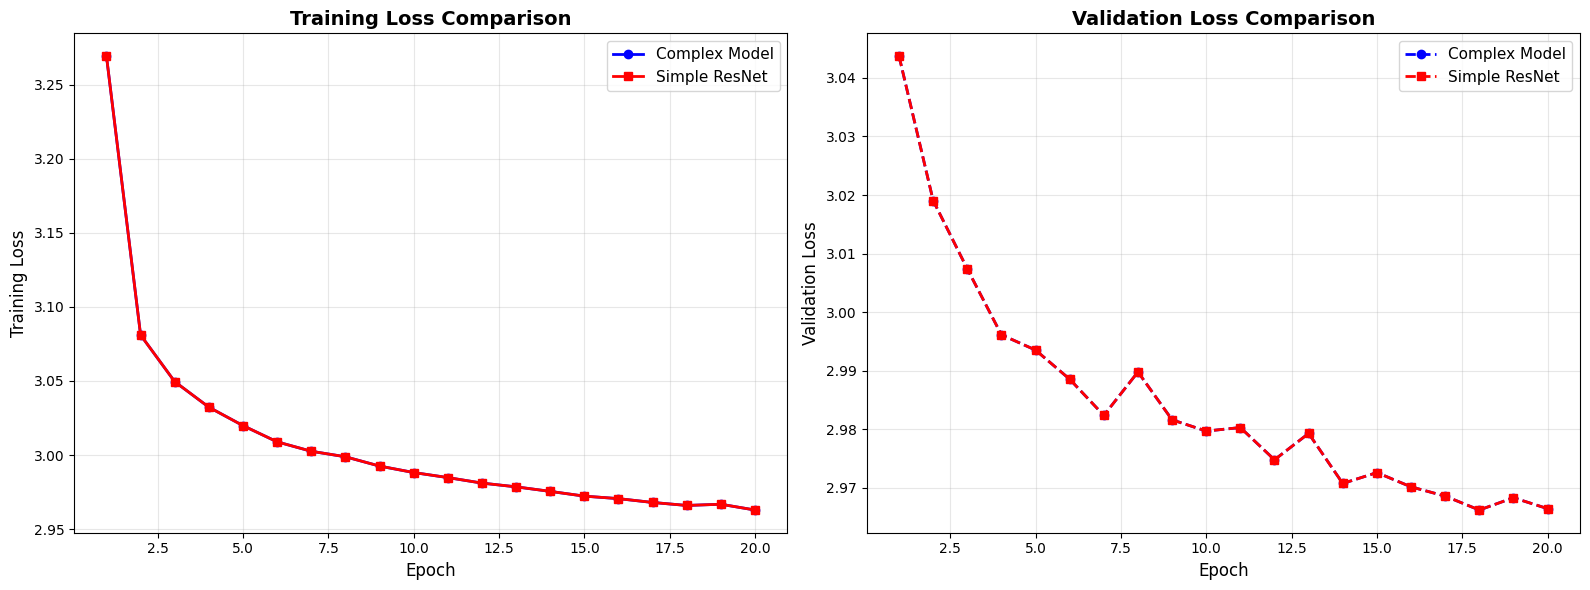


MODEL COMPARISON SUMMARY

Complex Transformer Model:
  Final Training Loss:   2.9629
  Final Validation Loss: 2.9665
  Best Validation Loss:  2.9662

Simple ResNet Baseline:
  Final Training Loss:   2.9629
  Final Validation Loss: 2.9665
  Best Validation Loss:  2.9662



In [114]:
# Compare training curves: Complex vs Simple model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training loss comparison
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'b-', label='Complex Model', linewidth=2, marker='o')
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'r-', label='Simple ResNet', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Validation loss comparison
if 'val_loss_history' in simple_history and 'val_loss_history' in simple_history:
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'b--', label='Complex Model', linewidth=2, marker='o')
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'r--', label='Simple ResNet', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print("\nComplex Transformer Model:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\nSimple ResNet Baseline:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\n" + "=" * 80)

## Evaluate Simple Model Embeddings

Let's evaluate the quality of embeddings from the simple ResNet model and compare clustering metrics.

In [115]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extract embeddings from simple model
print("Extracting embeddings from simple ResNet model...")
simple_embeddings, simple_labels = extract_embeddings(simple_model, test_loader_classification)
print(f"Extracted {len(simple_embeddings)} embeddings with dimension {simple_embeddings.shape[1]}")

# Calculate clustering metrics for simple model
simple_metrics = calculate_clustering_metrics(simple_embeddings, simple_labels)
print("\n" + "=" * 80)
print("SIMPLE RESNET MODEL - CLUSTERING METRICS")
print_clustering_metrics(simple_metrics)

Extracting embeddings from simple ResNet model...
Extracted 1652 embeddings with dimension 1024

SIMPLE RESNET MODEL - CLUSTERING METRICS
CLUSTERING QUALITY METRICS
Number of samples: 1652
Number of classes: 5

Metrics:
  Silhouette Score:        -0.0094
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    14.1952
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 6.15
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 3             :  913 samples ( 55.3%)
  Class 2             :  256 samples ( 15.5%)
  Class 4             :  243 samples ( 14.7%)
  Class 0             :  184 samples ( 11.1%)
  Class 1             :   56 samples (  3.4%)



Generating PCA visualization for simple model...


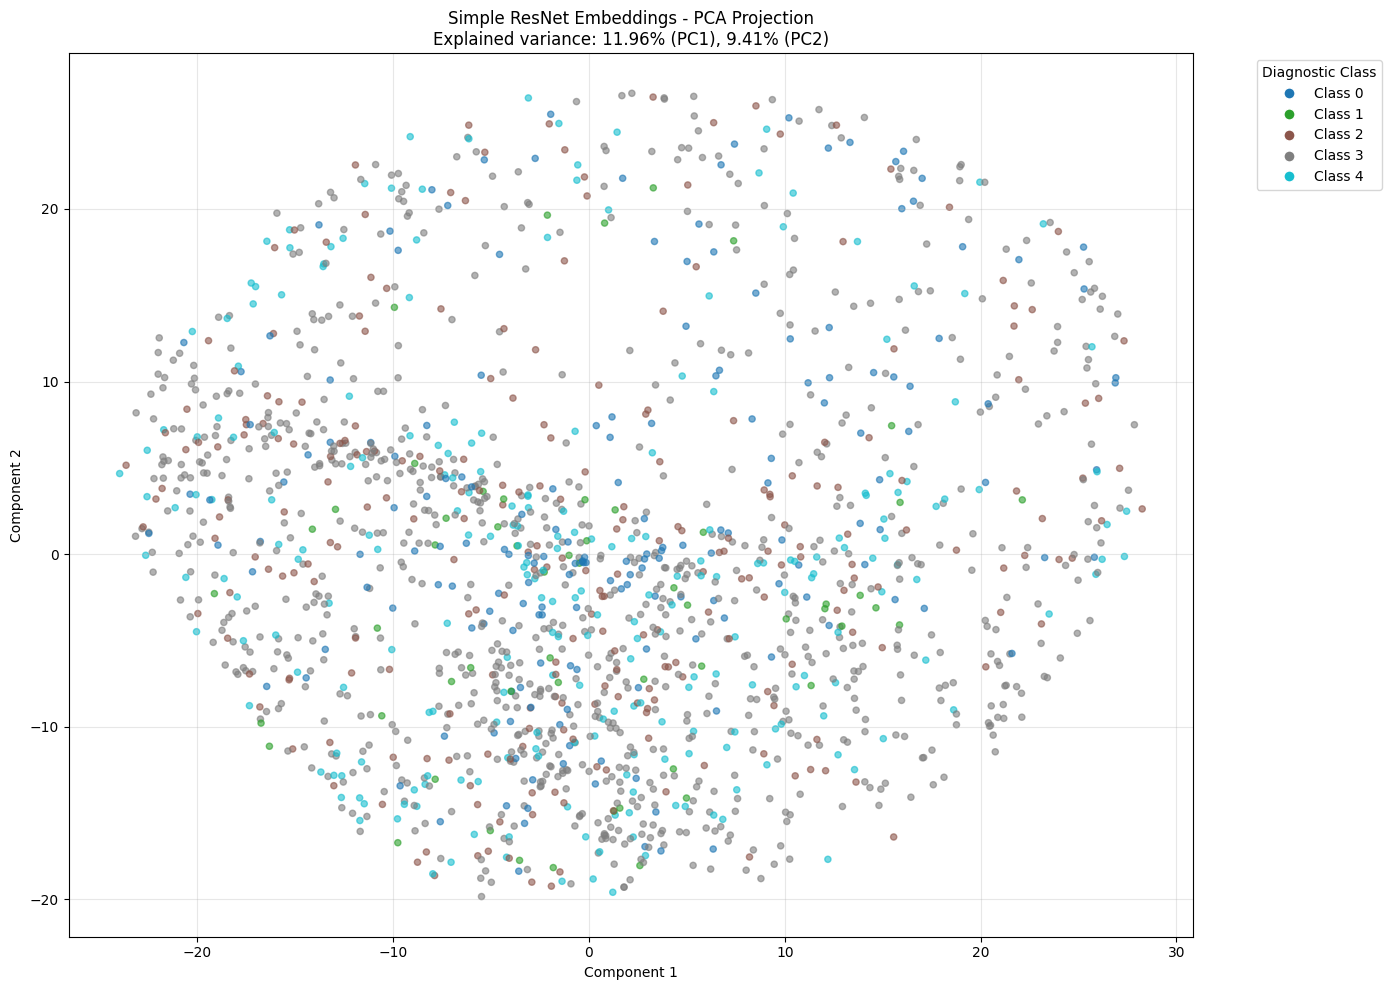

In [116]:
# Visualize simple model embeddings with PCA
print("\nGenerating PCA visualization for simple model...")
simple_embeddings_2d_pca, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='pca', 
    title='Simple ResNet Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization for simple model...


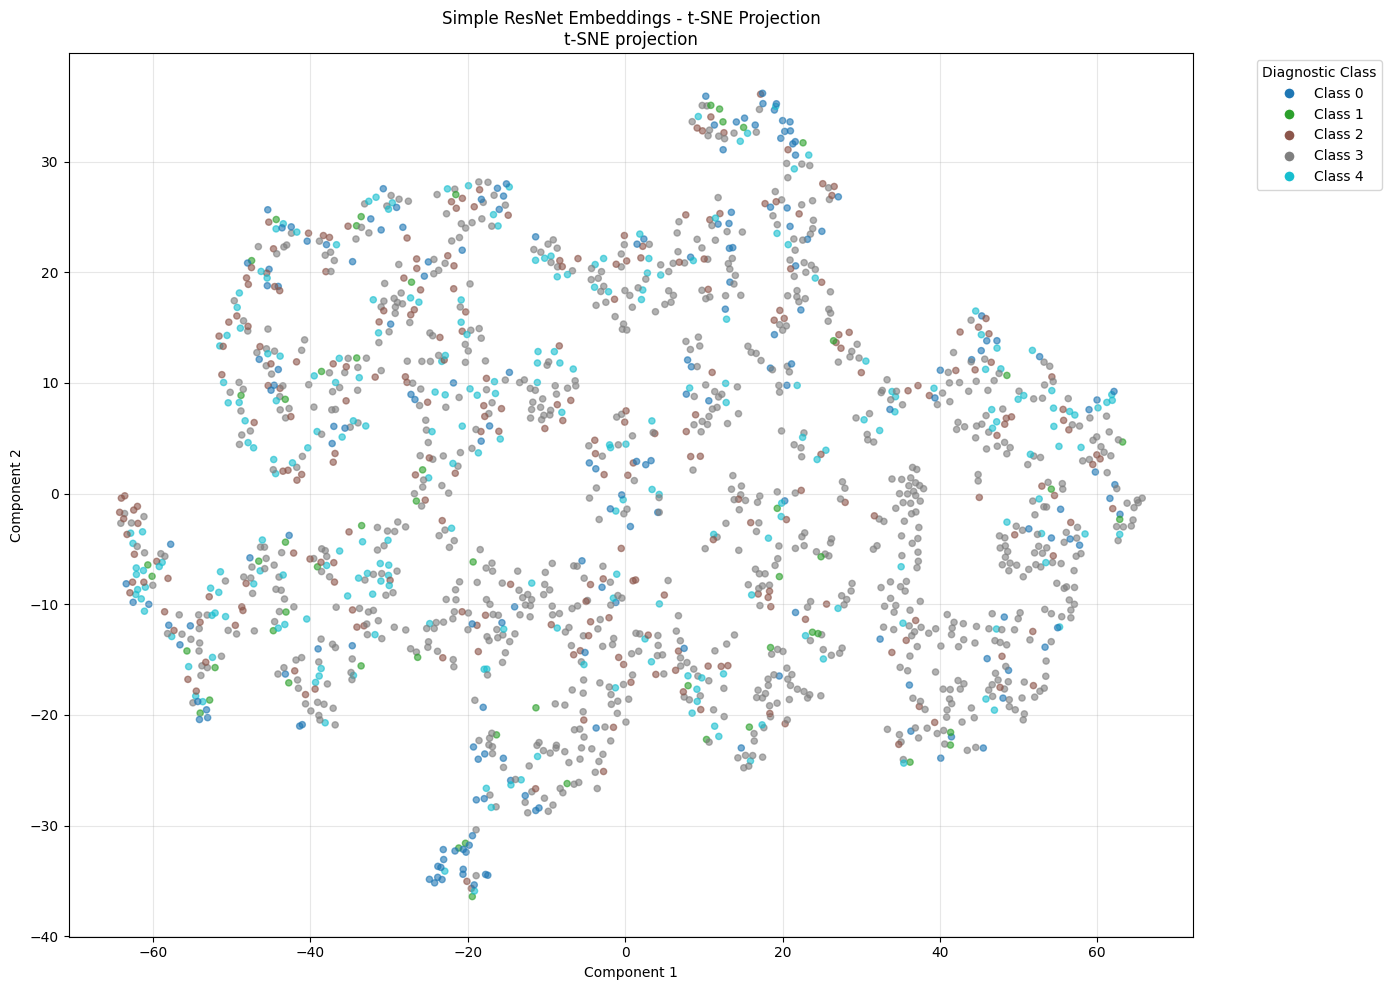

In [117]:
# Visualize simple model embeddings with t-SNE
print("\nGenerating t-SNE visualization for simple model...")
simple_embeddings_2d_tsne, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='tsne', 
    title='Simple ResNet Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

## Final Comparison & Analysis

Let's create a comprehensive comparison between the two models to identify what's working and what's not.

In [ ]:
# Comprehensive comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Total Parameters',
        'Final Training Loss',
        'Final Validation Loss',
        'Best Validation Loss',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score',
        'Embedding Dimension'
    ],
    'Complex Transformer': [
        f"{sum(p.numel() for p in model.parameters()):,}",
        f"{history['loss_history'][-1]:.4f}",
        f"{history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in history else "N/A",
        f"{min(history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in history else "N/A",
        f"{metrics['silhouette_score']:.4f}",
        f"{metrics['davies_bouldin_score']:.4f}",
        f"{metrics['calinski_harabasz_score']:.2f}",
        f"{embeddings.shape[1]}"
    ],
    'Simple ResNet': [
        f"{sum(p.numel() for p in simple_model.parameters()):,}",
        f"{simple_history['loss_history'][-1]:.4f}",
        f"{simple_history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{min(simple_history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{simple_metrics['silhouette_score']:.4f}",
        f"{simple_metrics['davies_bouldin_score']:.4f}",
        f"{simple_metrics['calinski_harabasz_score']:.2f}",
        f"{simple_embeddings.shape[1]}"
    ],
    'Better': [
        'Simple (fewer params)',
        'Lower is better',
        'Lower is better',
        'Lower is better',
        'Higher is better',
        'Lower is better',
        'Higher is better',
        'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Determine winner for each metric
print("\n📊 METRIC-BY-METRIC ANALYSIS:\n")

def compare_metric(name, complex_val, simple_val, higher_better=False):
    try:
        c = float(complex_val)
        s = float(simple_val)
        if higher_better:
            winner = "Simple ResNet" if s > c else "Complex Transformer"
            diff = ((s - c) / abs(c)) * 100
        else:
            winner = "Simple ResNet" if s < c else "Complex Transformer"
            diff = ((c - s) / abs(c)) * 100
        print(f"  {name:30s}: {winner:20s} (difference: {abs(diff):+.1f}%)")
    except:
        print(f"  {name:30s}: Unable to compare")

compare_metric("Training Loss", history['loss_history'][-1], simple_history['loss_history'][-1], False)
if 'val_loss_history' in history and 'val_loss_history' in simple_history:
    compare_metric("Validation Loss", history['val_loss_history'][-1], simple_history['val_loss_history'][-1], False)
compare_metric("Silhouette Score", metrics['silhouette_score'], simple_metrics['silhouette_score'], True)
compare_metric("Davies-Bouldin Score", metrics['davies_bouldin_score'], simple_metrics['davies_bouldin_score'], False)
compare_metric("Calinski-Harabasz Score", metrics['calinski_harabasz_score'], simple_metrics['calinski_harabasz_score'], True)

print("\n" + "=" * 100)


COMPREHENSIVE MODEL COMPARISON
                 Metric Complex Transformer Simple ResNet                Better
       Total Parameters             237,601    35,563,520 Simple (fewer params)
    Final Training Loss              4.6740        3.0205       Lower is better
  Final Validation Loss              4.5885        2.9245       Lower is better
   Best Validation Loss              4.5521        2.9245       Lower is better
       Silhouette Score             -0.0154       -0.0292      Higher is better
   Davies-Bouldin Score             13.6939        7.2548       Lower is better
Calinski-Harabasz Score                2.00         12.38      Higher is better
    Embedding Dimension                  44          1024                   N/A

📊 METRIC-BY-METRIC ANALYSIS:

  Training Loss                 : Simple ResNet        (difference: +35.4%)
  Validation Loss               : Simple ResNet        (difference: +36.3%)
  Silhouette Score              : Complex Transformer  (differenc

# Our Architecture

Try next:
1. Replacing Sinosudial Positional Encoding with learnable weights.
2. Set-wise Channel-wise Normalization.
3. Mix of both.

In [18]:
from src import ECGModelConfig, ECGEncoder

In [19]:
from typing import Tuple


def summarize_encoder_params(model) -> Tuple[int, int]:
    """
    Print a concise summary of the encoder's parameters and return (total, trainable).
    Uses existing `ecg_encoder`, `encoder_config`, `total_params`, `trainable_params` if available.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: {model.__class__.__name__}")
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}\n")

    print("Per top-level module parameter counts:")
    for name, module in model.named_children():
        mod_total = sum(p.numel() for p in module.parameters())
        mod_train = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  {name:20s} | total: {mod_total:10,} | trainable: {mod_train:10,}")

    print("\nParameter shapes (name, shape, trainable):")
    for name, p in model.named_parameters():
        print(f"  {name:60s} {tuple(p.shape)} {'trainable'}")

    return total, trainable


ecg_encoder = ECGEncoder(ECGModelConfig())

# Use the existing ecg_encoder variable in the notebook
total, trainable = summarize_encoder_params(ecg_encoder)

# If encoder_config and provided totals exist, print a quick consistency check
try:
    print("\nConsistency check with precomputed values (if present):")
    print(f"encoder_config: {encoder_config}")
    print(f"precomputed total_params:     {total_params:,}")
    print(f"precomputed trainable_params: {trainable_params:,}")
except NameError:
    pass

Model: ECGEncoder
Total params:     104,271,360
Trainable params: 104,271,360

Per top-level module parameter counts:
  time_encoder         | total: 50,430,464 | trainable: 50,430,464
  channel_encoder      | total: 50,686,464 | trainable: 50,686,464
  cross_attention      | total:  2,103,296 | trainable:  2,103,296
  fusion               | total:    525,824 | trainable:    525,824
  projection           | total:    525,312 | trainable:    525,312

Parameter shapes (name, shape, trainable):
  time_encoder.input_proj.weight                               (512, 12) trainable
  time_encoder.input_proj.bias                                 (512,) trainable
  time_encoder.encoder.layers.0.self_attn.in_proj_weight       (1536, 512) trainable
  time_encoder.encoder.layers.0.self_attn.in_proj_bias         (1536,) trainable
  time_encoder.encoder.layers.0.self_attn.out_proj.weight      (512, 512) trainable
  time_encoder.encoder.layers.0.self_attn.out_proj.bias        (512,) trainable
  time_enc

In [23]:
torch.cuda.empty_cache()

# Training

Epoch 1/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it, val_loss=3.3951]


Epoch [1/10] Train Loss: 3.9954 | Grad Norm: 7.19 | Val Loss: 3.6936 | Time: 158.9s | Total: 158.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_1.pt
New best model saved with loss: 3.9954
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/10 [Val]: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it, val_loss=3.1865]


Epoch [2/10] Train Loss: 3.5069 | Grad Norm: 5.95 | Val Loss: 3.5118 | Time: 160.2s | Total: 329.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_2.pt
New best model saved with loss: 3.5069
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it, val_loss=2.9985]


Epoch [3/10] Train Loss: 3.3993 | Grad Norm: 4.76 | Val Loss: 3.3551 | Time: 161.0s | Total: 501.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_3.pt
New best model saved with loss: 3.3993
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it, val_loss=3.0481]


Epoch [4/10] Train Loss: 3.3468 | Grad Norm: 3.79 | Val Loss: 3.3630 | Time: 159.5s | Total: 670.7s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_4.pt
New best model saved with loss: 3.3468
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it, val_loss=3.0883]


Epoch [5/10] Train Loss: 3.3313 | Grad Norm: 3.54 | Val Loss: 3.4435 | Time: 159.1s | Total: 840.3s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_5.pt
New best model saved with loss: 3.3313
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 6/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it, val_loss=3.0553]


Epoch [6/10] Train Loss: 3.3190 | Grad Norm: 3.27 | Val Loss: 3.3789 | Time: 157.8s | Total: 1008.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_6.pt
New best model saved with loss: 3.3190
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 7/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it, val_loss=3.0190]


Epoch [7/10] Train Loss: 3.2932 | Grad Norm: 3.45 | Val Loss: 3.3682 | Time: 158.4s | Total: 1177.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_7.pt
New best model saved with loss: 3.2932
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 8/10 [Val]: 100%|██████████| 3/3 [00:06<00:00,  2.22s/it, val_loss=3.0315]


Epoch [8/10] Train Loss: 3.2978 | Grad Norm: 3.04 | Val Loss: 3.3470 | Time: 158.1s | Total: 1345.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_8.pt
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 9/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it, val_loss=3.0217]


Epoch [9/10] Train Loss: 3.2958 | Grad Norm: 2.92 | Val Loss: 3.3203 | Time: 158.8s | Total: 1514.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_9.pt
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 10/10 [Val]: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it, val_loss=2.9596]


Epoch [10/10] Train Loss: 3.2659 | Grad Norm: 2.82 | Val Loss: 3.3226 | Time: 160.3s | Total: 1683.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_10.pt
New best model saved with loss: 3.2659
Removed old checkpoint: checkpoint_epoch_10.pt

Training completed in 1693.3s (28.2 minutes)


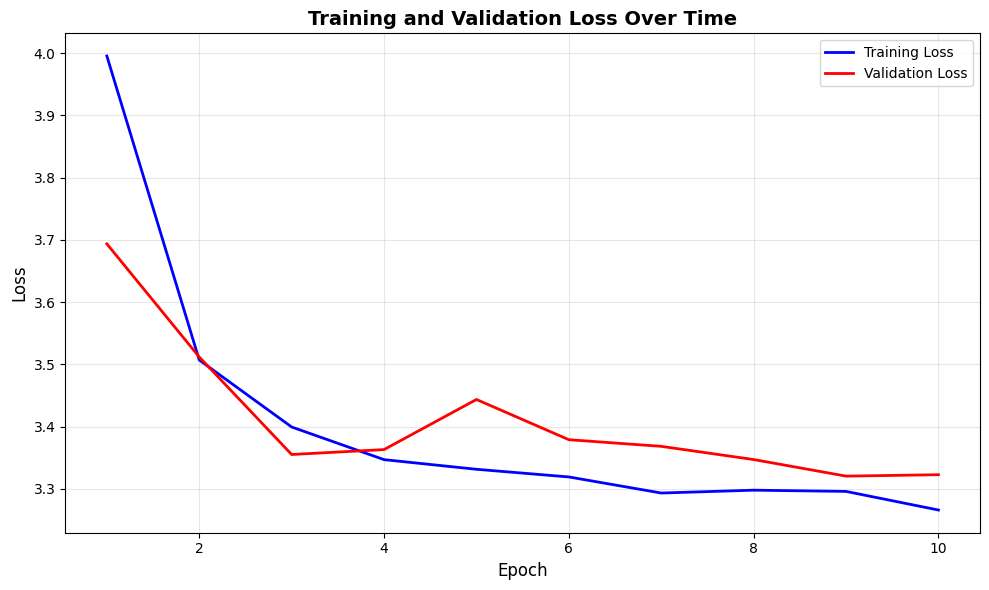


Final Training Loss: 3.2659
Final Validation Loss: 3.3226
Best Validation Loss: 3.3203 (Epoch 9)


In [21]:
import matplotlib.pyplot as plt

model = ECGEncoder(ECGModelConfig())
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = NTXentLoss(temperature=0.5)

simple_history = train(
    model=model,
    dataset=train_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=ECGModelConfig(),
    batch_size=86,
    epochs=10,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)


plt.figure(figsize=(10, 6))
epochs_range = range(1, len(simple_history['loss_history']) + 1)
plt.plot(epochs_range, simple_history['loss_history'], 'b-', label='Training Loss', linewidth=2)
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    plt.plot(epochs_range, simple_history['val_loss_history'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    print(f"Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"Best Validation Loss: {min(simple_history['val_loss_history']):.4f} (Epoch {simple_history['val_loss_history'].index(min(simple_history['val_loss_history'])) + 1})")

# Evaluation

In [22]:
# Extract embeddings from the test set
print("Extracting embeddings from test set...")

test_dataset = ECGDataset(
    X=X_train_filtered,
    y=y_train_int,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
embeddings, labels = extract_embeddings(model, test_loader)
print(f"Extracted {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
print(f"Found {len(set(labels))} unique classes: {sorted(set(labels))}")

Extracting embeddings from test set...
Extracted 1466 embeddings with dimension 512
Found 5 unique classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [23]:
# Calculate and print clustering metrics
metrics = calculate_clustering_metrics(embeddings, labels)
print_clustering_metrics(metrics)

CLUSTERING QUALITY METRICS
Number of samples: 1466
Number of classes: 5

Metrics:
  Silhouette Score:        -0.0185
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    20.9857
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 1.26
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 3             :  975 samples ( 66.5%)
  Class 4             :  193 samples ( 13.2%)
  Class 0             :  134 samples (  9.1%)
  Class 2             :  113 samples (  7.7%)
  Class 1             :   51 samples (  3.5%)



Generating PCA visualization...


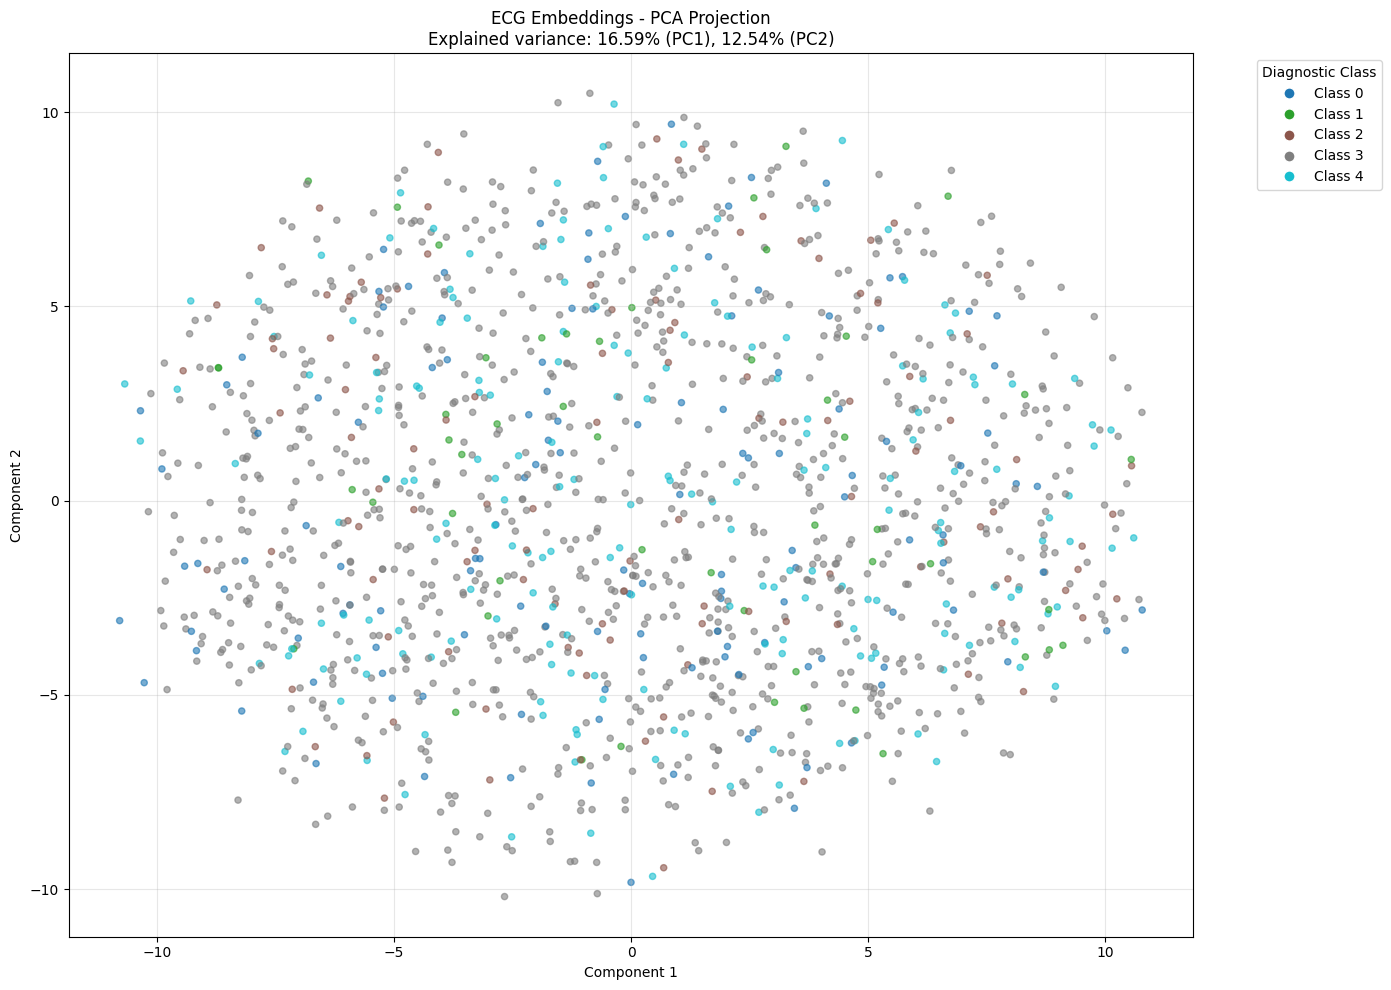

In [24]:
# Visualize embeddings with PCA
print("\nGenerating PCA visualization...")
embeddings_2d_pca, unique_labels = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='pca', 
    title='ECG Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization...


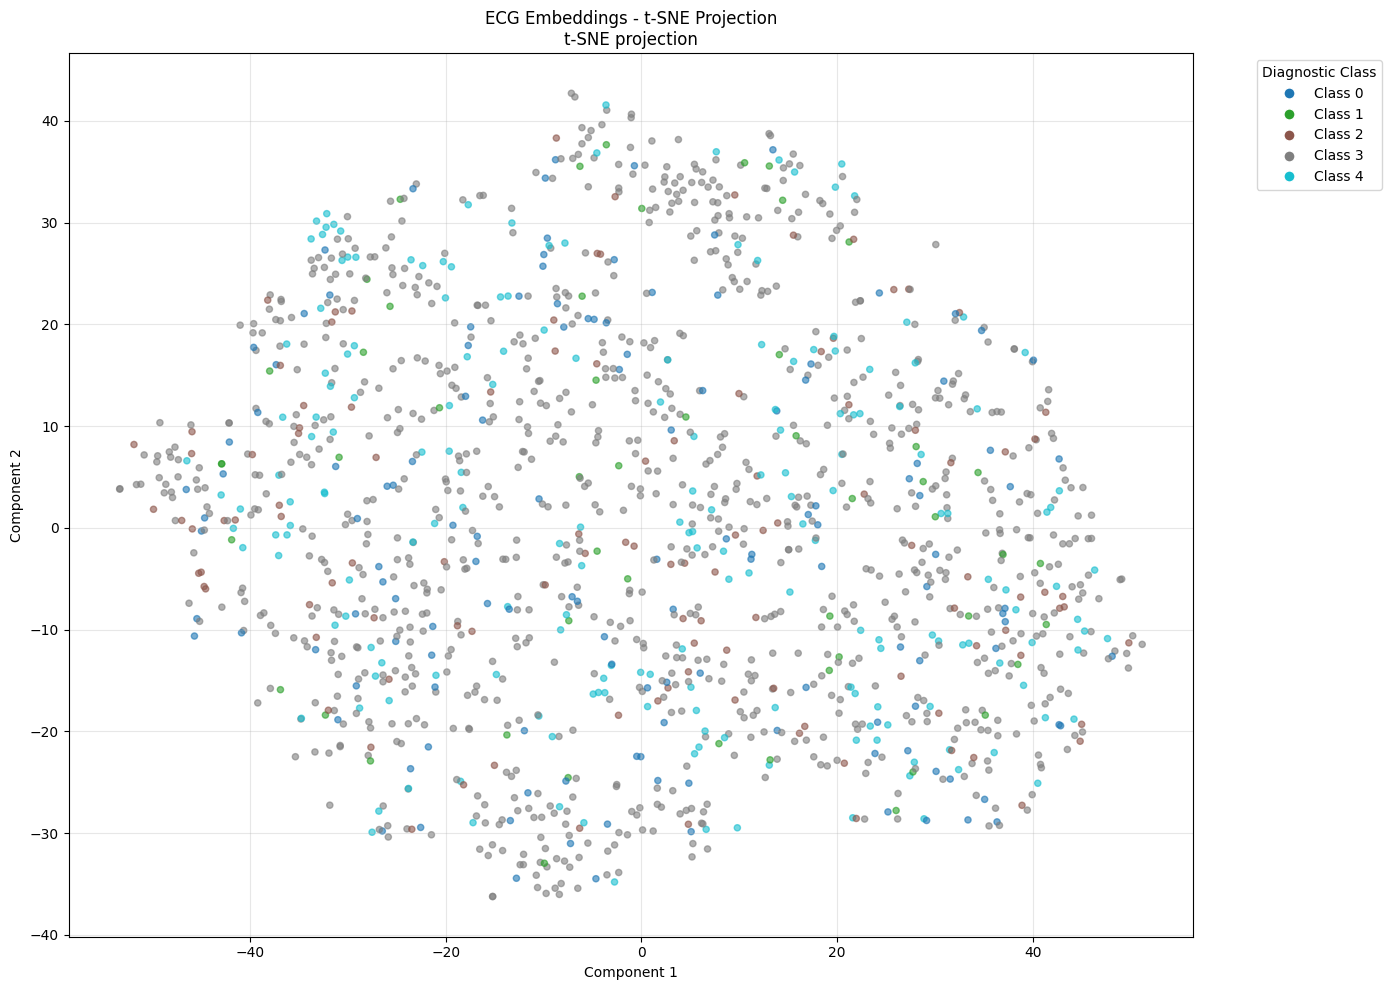

In [25]:
# Visualize embeddings with t-SNE (optional, takes longer)
print("\nGenerating t-SNE visualization...")
embeddings_2d_tsne, _ = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='tsne', 
    title='ECG Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

# Downstream classification

## Simple Classifier with Frozen Encoder

We'll use the pre-trained encoder as a frozen feature extractor and add a simple classification head on top. This allows us to evaluate the quality of the learned representations on downstream classification tasks.

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm


class SimpleClassifier(nn.Module):
    """
    Simple classifier that uses an encoder as backbone.
    
    Args:
        encoder: Pre-trained encoder model
        num_classes: Number of output classes
        hidden_dim: Hidden dimension for classification head (optional)
        encoder_dim: Output dimension of the encoder
        freeze_encoder: If True, freeze encoder weights; if False, allow joint training
    """
    
    def __init__(self, encoder, num_classes, hidden_dim=None, encoder_dim=1024, freeze_encoder=False):
        super().__init__()
        self.encoder = encoder
        self.freeze_encoder = freeze_encoder
        
        # Freeze encoder weights if requested
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Classification head
        if hidden_dim is not None:
            self.classifier = nn.Sequential(
                nn.Linear(encoder_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim, num_classes)
            )
        else:
            self.classifier = nn.Linear(encoder_dim, num_classes)
    
    def forward(self, x):
        # Extract features (with or without gradients based on freeze_encoder)
        if self.freeze_encoder:
            with torch.no_grad():
                features, _ = self.encoder(x)
        else:
            features, _ = self.encoder(x)
        
        # Classify
        logits = self.classifier(features.to(x.dtype))
        return logits


def train_classifier(
    encoder,
    train_loader,
    val_loader,
    num_classes,
    hidden_dim=256,
    num_epochs=20,
    learning_rate=1e-3,
    device=None,
    patience=5,
    freeze_encoder=True,
    encoder_lr=1e-4
):
    """
    Train a classifier on top of an encoder.
    
    Args:
        encoder: Pre-trained encoder model
        train_loader: DataLoader for training data (with numerical labels)
        val_loader: DataLoader for validation data (with numerical labels)
        num_classes: Number of classes
        hidden_dim: Hidden dimension for classification head
        num_epochs: Maximum number of training epochs
        learning_rate: Learning rate for classifier head
        device: Device to train on
        patience: Early stopping patience
        freeze_encoder: If True, freeze encoder; if False, train encoder jointly
        encoder_lr: Learning rate for encoder (only used if freeze_encoder=False)
    
    Returns:
        model: Trained classifier
        history: Dictionary containing training history
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create model
    model = SimpleClassifier(encoder, num_classes, hidden_dim=hidden_dim, encoder_dim=512, 
                            freeze_encoder=freeze_encoder)
    model = model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer setup based on freeze_encoder flag
    if freeze_encoder:
        # Only optimize classifier parameters
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
    else:
        # Optimize both encoder and classifier with different learning rates
        optimizer = torch.optim.Adam([
            {'params': model.encoder.parameters(), 'lr': encoder_lr},
            {'params': model.classifier.parameters(), 'lr': learning_rate}
        ])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    # Print training configuration
    print(f"Training classifier on {device}")
    print(f"Training mode: {'Frozen encoder' if freeze_encoder else 'Joint training (encoder + classifier)'}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")
    if not freeze_encoder:
        print(f"Encoder learning rate: {encoder_lr}")
        print(f"Classifier learning rate: {learning_rate}")
    else:
        print(f"Classifier learning rate: {learning_rate}")
    print()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        if freeze_encoder:
            model.encoder.eval()  # Keep encoder in eval mode when frozen
        
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for signals, labels in pbar:
            signals, labels = signals.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(signals)
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item() * signals.size(0)
            train_preds.extend(logits.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item()})
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for signals, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ', leave=False):
                signals, labels = signals.to(device), labels.to(device)
                
                logits = model(signals)
                loss = criterion(logits, labels)
                
                val_loss += loss.item() * signals.size(0)
                val_preds.extend(logits.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}, Val F1: {val_f1:.4f}')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'  ✓ New best validation accuracy!')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        print()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history


def evaluate_classifier(model, test_loader, idx_to_label=None, device=None):
    """
    Evaluate classifier on test set.
    
    Args:
        model: Trained classifier
        test_loader: DataLoader for test data
        idx_to_label: Optional mapping from indices to label names
        device: Device to run evaluation on
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in tqdm(test_loader, desc='Evaluating'):
            signals, labels = signals.to(device), labels.to(device)
            
            logits = model(signals)
            preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    metrics = {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    # Print results
    print("=" * 60)
    print("TEST SET EVALUATION")
    print("=" * 60)
    print(f"Accuracy:          {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro):    {f1_macro:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print("=" * 60)
    print()
    
    # Classification report
    if idx_to_label is not None:
        target_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    else:
        target_names = None
    
    print("CLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    return metrics


In [30]:
# Train the classifier using the pre-trained encoder
train_loader_classification=DataLoader(train_dataset_classification, batch_size=64, shuffle=True)
val_loader_classification=DataLoader(val_dataset_classification, batch_size=128, shuffle=False)

classifier, training_history = train_classifier(
    encoder=model,  # Your pre-trained encoder
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=512,
    num_epochs=25,
    learning_rate=1e-3,
    patience=5,
    freeze_encoder=False,  # Fine-tune the encoder as well
)

Training classifier on cuda
Training mode: Joint training (encoder + classifier)
Total parameters: 104,536,581
Trainable parameters: 265,221
Frozen parameters: 104,271,360
Encoder learning rate: 0.0001
Classifier learning rate: 0.001



Epoch 1/25 [Train]: 100%|██████████| 23/23 [00:27<00:00,  1.19s/it, loss=1.11] 


Epoch 1/25:
  Train Loss: 1.1653, Train Acc: 0.6412
  Val Loss:   1.1267, Val Acc:   0.6518, Val F1: 0.5144
  ✓ New best validation accuracy!



Epoch 2/25 [Train]: 100%|██████████| 23/23 [00:27<00:00,  1.19s/it, loss=1.14] 


Epoch 2/25:
  Train Loss: 1.0576, Train Acc: 0.6651
  Val Loss:   1.1515, Val Acc:   0.6518, Val F1: 0.5144



Epoch 3/25 [Train]:  65%|██████▌   | 15/23 [00:19<00:10,  1.28s/it, loss=1.02] 


KeyboardInterrupt: 

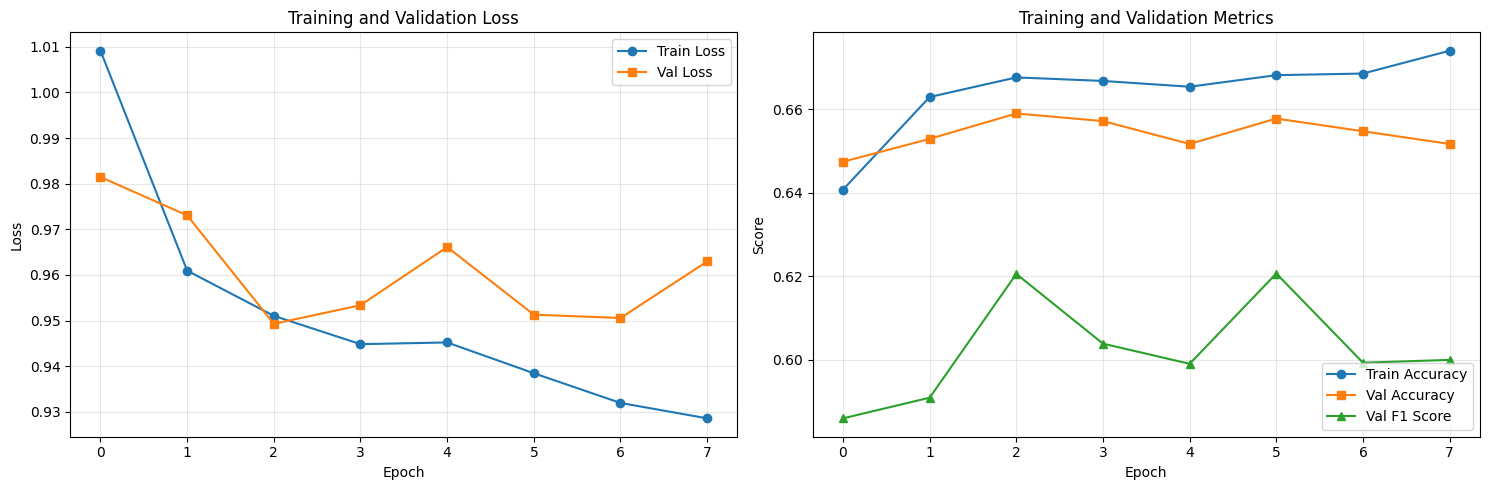


Best Training Accuracy: 0.6740
Best Validation Accuracy: 0.6590
Best Validation F1: 0.6206


In [58]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(training_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(training_history['val_acc'], label='Val Accuracy', marker='s')
axes[1].plot(training_history['val_f1'], label='Val F1 Score', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
print(f"\nBest Training Accuracy: {max(training_history['train_acc']):.4f}")
print(f"Best Validation Accuracy: {max(training_history['val_acc']):.4f}")
print(f"Best Validation F1: {max(training_history['val_f1']):.4f}")

In [59]:
# Evaluate on test set
test_metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

Evaluating: 100%|██████████| 52/52 [00:02<00:00, 23.54it/s]

TEST SET EVALUATION
Accuracy:          0.6556
F1 Score (weighted): 0.6000
F1 Score (macro):    0.3966
Precision:         0.6214
Recall:            0.6556

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          CD       0.60      0.24      0.35       184
         HYP       0.00      0.00      0.00        56
          MI       0.57      0.24      0.34       256
        NORM       0.66      0.96      0.78       913
        STTC       0.68      0.42      0.52       243

    accuracy                           0.66      1652
   macro avg       0.50      0.37      0.40      1652
weighted avg       0.62      0.66      0.60      1652




/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

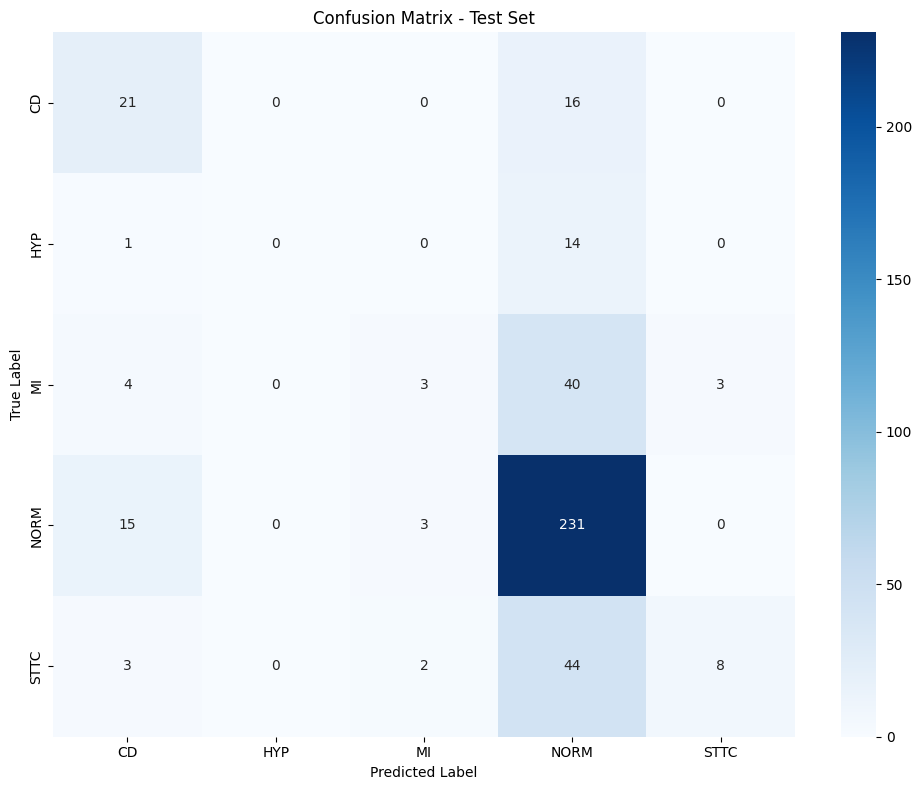


Per-Class Accuracy:
  CD                  : 0.5676 (21/37)
  HYP                 : 0.0000 (0/15)
  MI                  : 0.0600 (3/50)
  NORM                : 0.9277 (231/249)
  STTC                : 0.1404 (8/57)


In [62]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

### Understanding the Results

The classifier evaluation provides insights into how well the pre-trained encoder's representations transfer to the downstream classification task:

**Key Metrics:**
- **Accuracy**: Overall percentage of correct predictions
- **F1 Score (Weighted)**: Harmonic mean of precision and recall, weighted by class support
- **F1 Score (Macro)**: Average F1 across all classes (treats all classes equally)
- **Precision**: Percentage of positive predictions that are correct
- **Recall**: Percentage of actual positives that are identified

**Interpreting Performance:**
- High test accuracy indicates good representation learning
- Compare with training from scratch to quantify the benefit of pre-training
- Per-class metrics reveal which diagnostic classes are easier/harder to classify
- Confusion matrix shows common misclassification patterns

**Architecture Notes:**
- The encoder is **frozen** (not updated during training)
- Only the classification head learns during training
- This tests the quality of the learned representations for downstream tasks

### Optional: Baseline Comparison

To validate that the pre-trained encoder learned useful representations, you can compare against a randomly initialized encoder:

In [ ]:
# Optional: Train classifier with random encoder (baseline)
# This helps quantify the benefit of pre-training

# Create a new random encoder with the same architecture
random_encoder = ECGEncoder(
    input_channels=12,
    d_model=512,
    nhead=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Train classifier on random features
print("Training classifier with RANDOM encoder (baseline)...")
baseline_classifier, baseline_history = train_classifier(
    encoder=random_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=30,
    learning_rate=1e-3,
    patience=5
)

# Evaluate baseline
print("\n" + "="*60)
print("BASELINE EVALUATION (Random Encoder)")
print("="*60)
baseline_metrics = evaluate_classifier(
    model=baseline_classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

# Compare results
print("\n" + "="*60)
print("COMPARISON: Pre-trained vs Random Encoder")
print("="*60)
print(f"Pre-trained Encoder Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Random Encoder Test Accuracy:      {baseline_metrics['accuracy']:.4f}")
print(f"Improvement:                        {(test_metrics['accuracy'] - baseline_metrics['accuracy']):.4f}")
print(f"Relative Improvement:               {((test_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy'] * 100):.2f}%")
print("="*60)

---

## Summary: Downstream Classification Workflow

This section evaluates the quality of the learned encoder representations using a simple downstream classification task. Here's the complete workflow:

### 1. **Data Preparation**
   - Created datasets with numerical labels using `ECGDataset(map_labels_to_int=True)`
   - Split into train/val/test sets with proper DataLoaders

### 2. **Model Architecture**
   - `SimpleClassifier`: Frozen encoder + trainable classification head
   - Only the classification head parameters are updated during training
   - This isolates the evaluation to the encoder's representation quality

### 3. **Training**
   - Uses `train_classifier()` function that accepts any encoder
   - Early stopping based on validation accuracy
   - Tracks loss, accuracy, and F1 score
   - Returns trained model and training history

### 4. **Evaluation**
   - Comprehensive metrics: accuracy, F1 (weighted & macro), precision, recall
   - Classification report per class
   - Confusion matrix visualization
   - Per-class accuracy breakdown

### 5. **Baseline Comparison (Optional)**
   - Compare against randomly initialized encoder
   - Quantifies the benefit of contrastive pre-training
   - Shows relative improvement from learned representations

### Usage Example:
```python
# Train classifier
classifier, history = train_classifier(
    encoder=your_pretrained_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=num_classes
)

# Evaluate
metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification
)
```

This approach is a standard method for evaluating self-supervised learning models on downstream tasks.